### Case Study - 5 Cybersecurity Automation of Firewall Traffic 

In [1]:
import os
import pandas as pd
import re
import datetime as dt
import numpy as np
from IPython.display import display
import warnings
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import metrics as mt
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, accuracy_score, confusion_matrix, average_precision_score
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn import metrics as mt
from sklearn.model_selection import cross_validate, cross_val_predict, StratifiedKFold, GridSearchCV, RandomizedSearchCV
warnings.filterwarnings('ignore')

In [2]:
#Bring in the data
df = pd.read_csv('log2.csv') # read in the csv file

In [3]:
df.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Action                65532 non-null  object
 5   Bytes                 65532 non-null  int64 
 6   Bytes Sent            65532 non-null  int64 
 7   Bytes Received        65532 non-null  int64 
 8   Packets               65532 non-null  int64 
 9   Elapsed Time (sec)    65532 non-null  int64 
 10  pkts_sent             65532 non-null  int64 
 11  pkts_received         65532 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


In [5]:
df.describe()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
count,65532.000000,65532.000000,65532.000000,65532.000000,6.553200e+04,6.553200e+04,6.553200e+04,6.553200e+04,65532.000000,65532.000000,65532.000000
mean,49391.969343,10577.385812,19282.972761,2671.049930,9.712395e+04,2.238580e+04,7.473815e+04,1.028660e+02,65.833577,41.399530,61.466505
std,15255.712537,18466.027039,21970.689669,9739.162278,5.618439e+06,3.828139e+06,2.463208e+06,5.133002e+03,302.461762,3218.871288,2223.332271
min,0.000000,0.000000,0.000000,0.000000,6.000000e+01,6.000000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
25%,49183.000000,80.000000,0.000000,0.000000,6.600000e+01,6.600000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
50%,53776.500000,445.000000,8820.500000,53.000000,1.680000e+02,9.000000e+01,7.900000e+01,2.000000e+00,15.000000,1.000000,1.000000
75%,58638.000000,15000.000000,38366.250000,443.000000,7.522500e+02,2.100000e+02,4.490000e+02,6.000000e+00,30.000000,3.000000,2.000000
max,65534.000000,65535.000000,65535.000000,65535.000000,1.269359e+09,9.484772e+08,3.208818e+08,1.036116e+06,10824.000000,747520.000000,327208.000000


##### Missing value analysis

In [6]:
# Validate null values in the csv file
df.isnull().sum().sum()

0

#### Target

In [7]:
df['Action'].value_counts()

allow         37640
deny          14987
drop          12851
reset-both       54
Name: Action, dtype: int64

In [8]:
target_mod = {
    'allow':'allow',
    'deny':'deny',
    'drop':'deny',
    'reset-both':'deny'
}
df['Action_mod'] = df['Action'].map(target_mod)
df['Action_mod'] = df['Action_mod'].astype('category')

In [9]:
df

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,Action_mod
0,57222,53,54587,53,allow,177,94,83,2,30,1,1,allow
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9,allow
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1,allow
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7,allow
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18,allow
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65527,63691,80,13237,80,allow,314,192,122,6,15,4,2,allow
65528,50964,80,13485,80,allow,4680740,67312,4613428,4675,77,985,3690,allow
65529,54871,445,0,0,drop,70,70,0,1,0,1,0,deny
65530,54870,445,0,0,drop,70,70,0,1,0,1,0,deny


In [10]:
df['Action_mod'].value_counts()

allow    37640
deny     27892
Name: Action_mod, dtype: int64

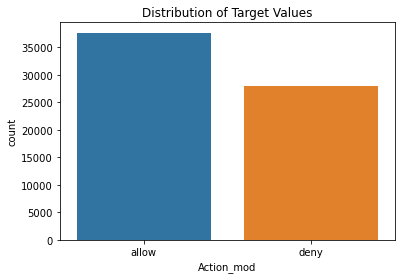

In [11]:
sns.countplot(x = "Action_mod", data = df)
plt.title("Distribution of Target Values")
plt.show()

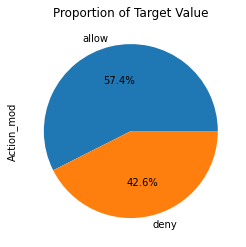

In [12]:
# Pie chart
df['Action_mod'].value_counts().plot.pie(autopct = "%.1f%%")
plt.title("Proportion of Target Value")
plt.show()

In [13]:
df['Action_mod'] = df['Action_mod'].replace(['deny', 'allow'], [0, 1])

df['Action_mod'].value_counts()

1    37640
0    27892
Name: Action_mod, dtype: int64

In [14]:
df = df.drop(['Action'],axis=1)

##### Independent Variable analysis

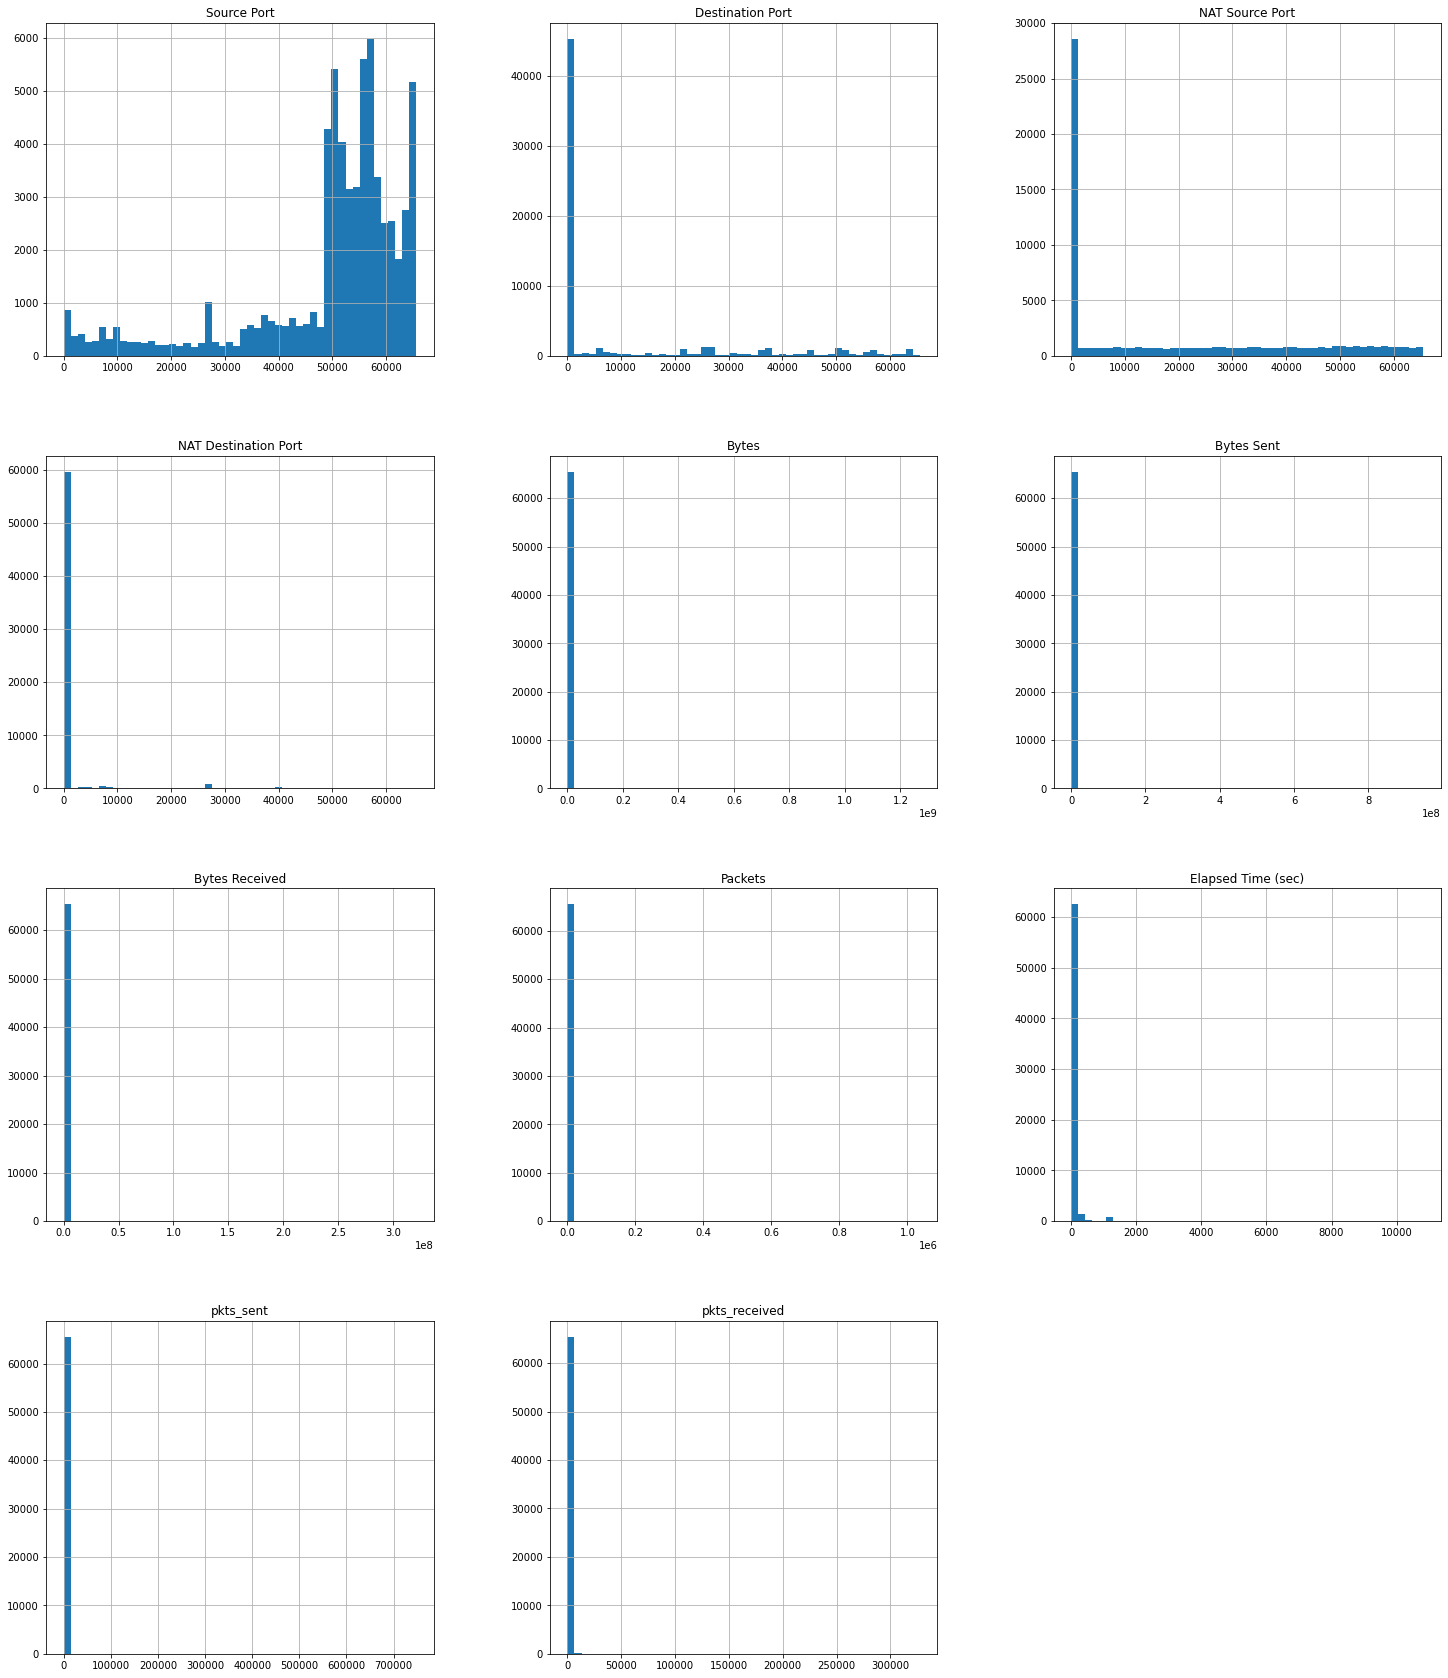

In [15]:
#Visualizing the hist of data to check normality of independent variable
df_X = df.drop(['Action_mod'],axis=1)
df_X.hist(bins=50,figsize=(25,30))
plt.show()

In [16]:
df.drop(['Action_mod'],axis=1).describe()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
count,65532.000000,65532.000000,65532.000000,65532.000000,6.553200e+04,6.553200e+04,6.553200e+04,6.553200e+04,65532.000000,65532.000000,65532.000000
mean,49391.969343,10577.385812,19282.972761,2671.049930,9.712395e+04,2.238580e+04,7.473815e+04,1.028660e+02,65.833577,41.399530,61.466505
std,15255.712537,18466.027039,21970.689669,9739.162278,5.618439e+06,3.828139e+06,2.463208e+06,5.133002e+03,302.461762,3218.871288,2223.332271
min,0.000000,0.000000,0.000000,0.000000,6.000000e+01,6.000000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
25%,49183.000000,80.000000,0.000000,0.000000,6.600000e+01,6.600000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
50%,53776.500000,445.000000,8820.500000,53.000000,1.680000e+02,9.000000e+01,7.900000e+01,2.000000e+00,15.000000,1.000000,1.000000
75%,58638.000000,15000.000000,38366.250000,443.000000,7.522500e+02,2.100000e+02,4.490000e+02,6.000000e+00,30.000000,3.000000,2.000000
max,65534.000000,65535.000000,65535.000000,65535.000000,1.269359e+09,9.484772e+08,3.208818e+08,1.036116e+06,10824.000000,747520.000000,327208.000000


Text(0.5, 1.0, 'HeatMap-Correlation Matrix')

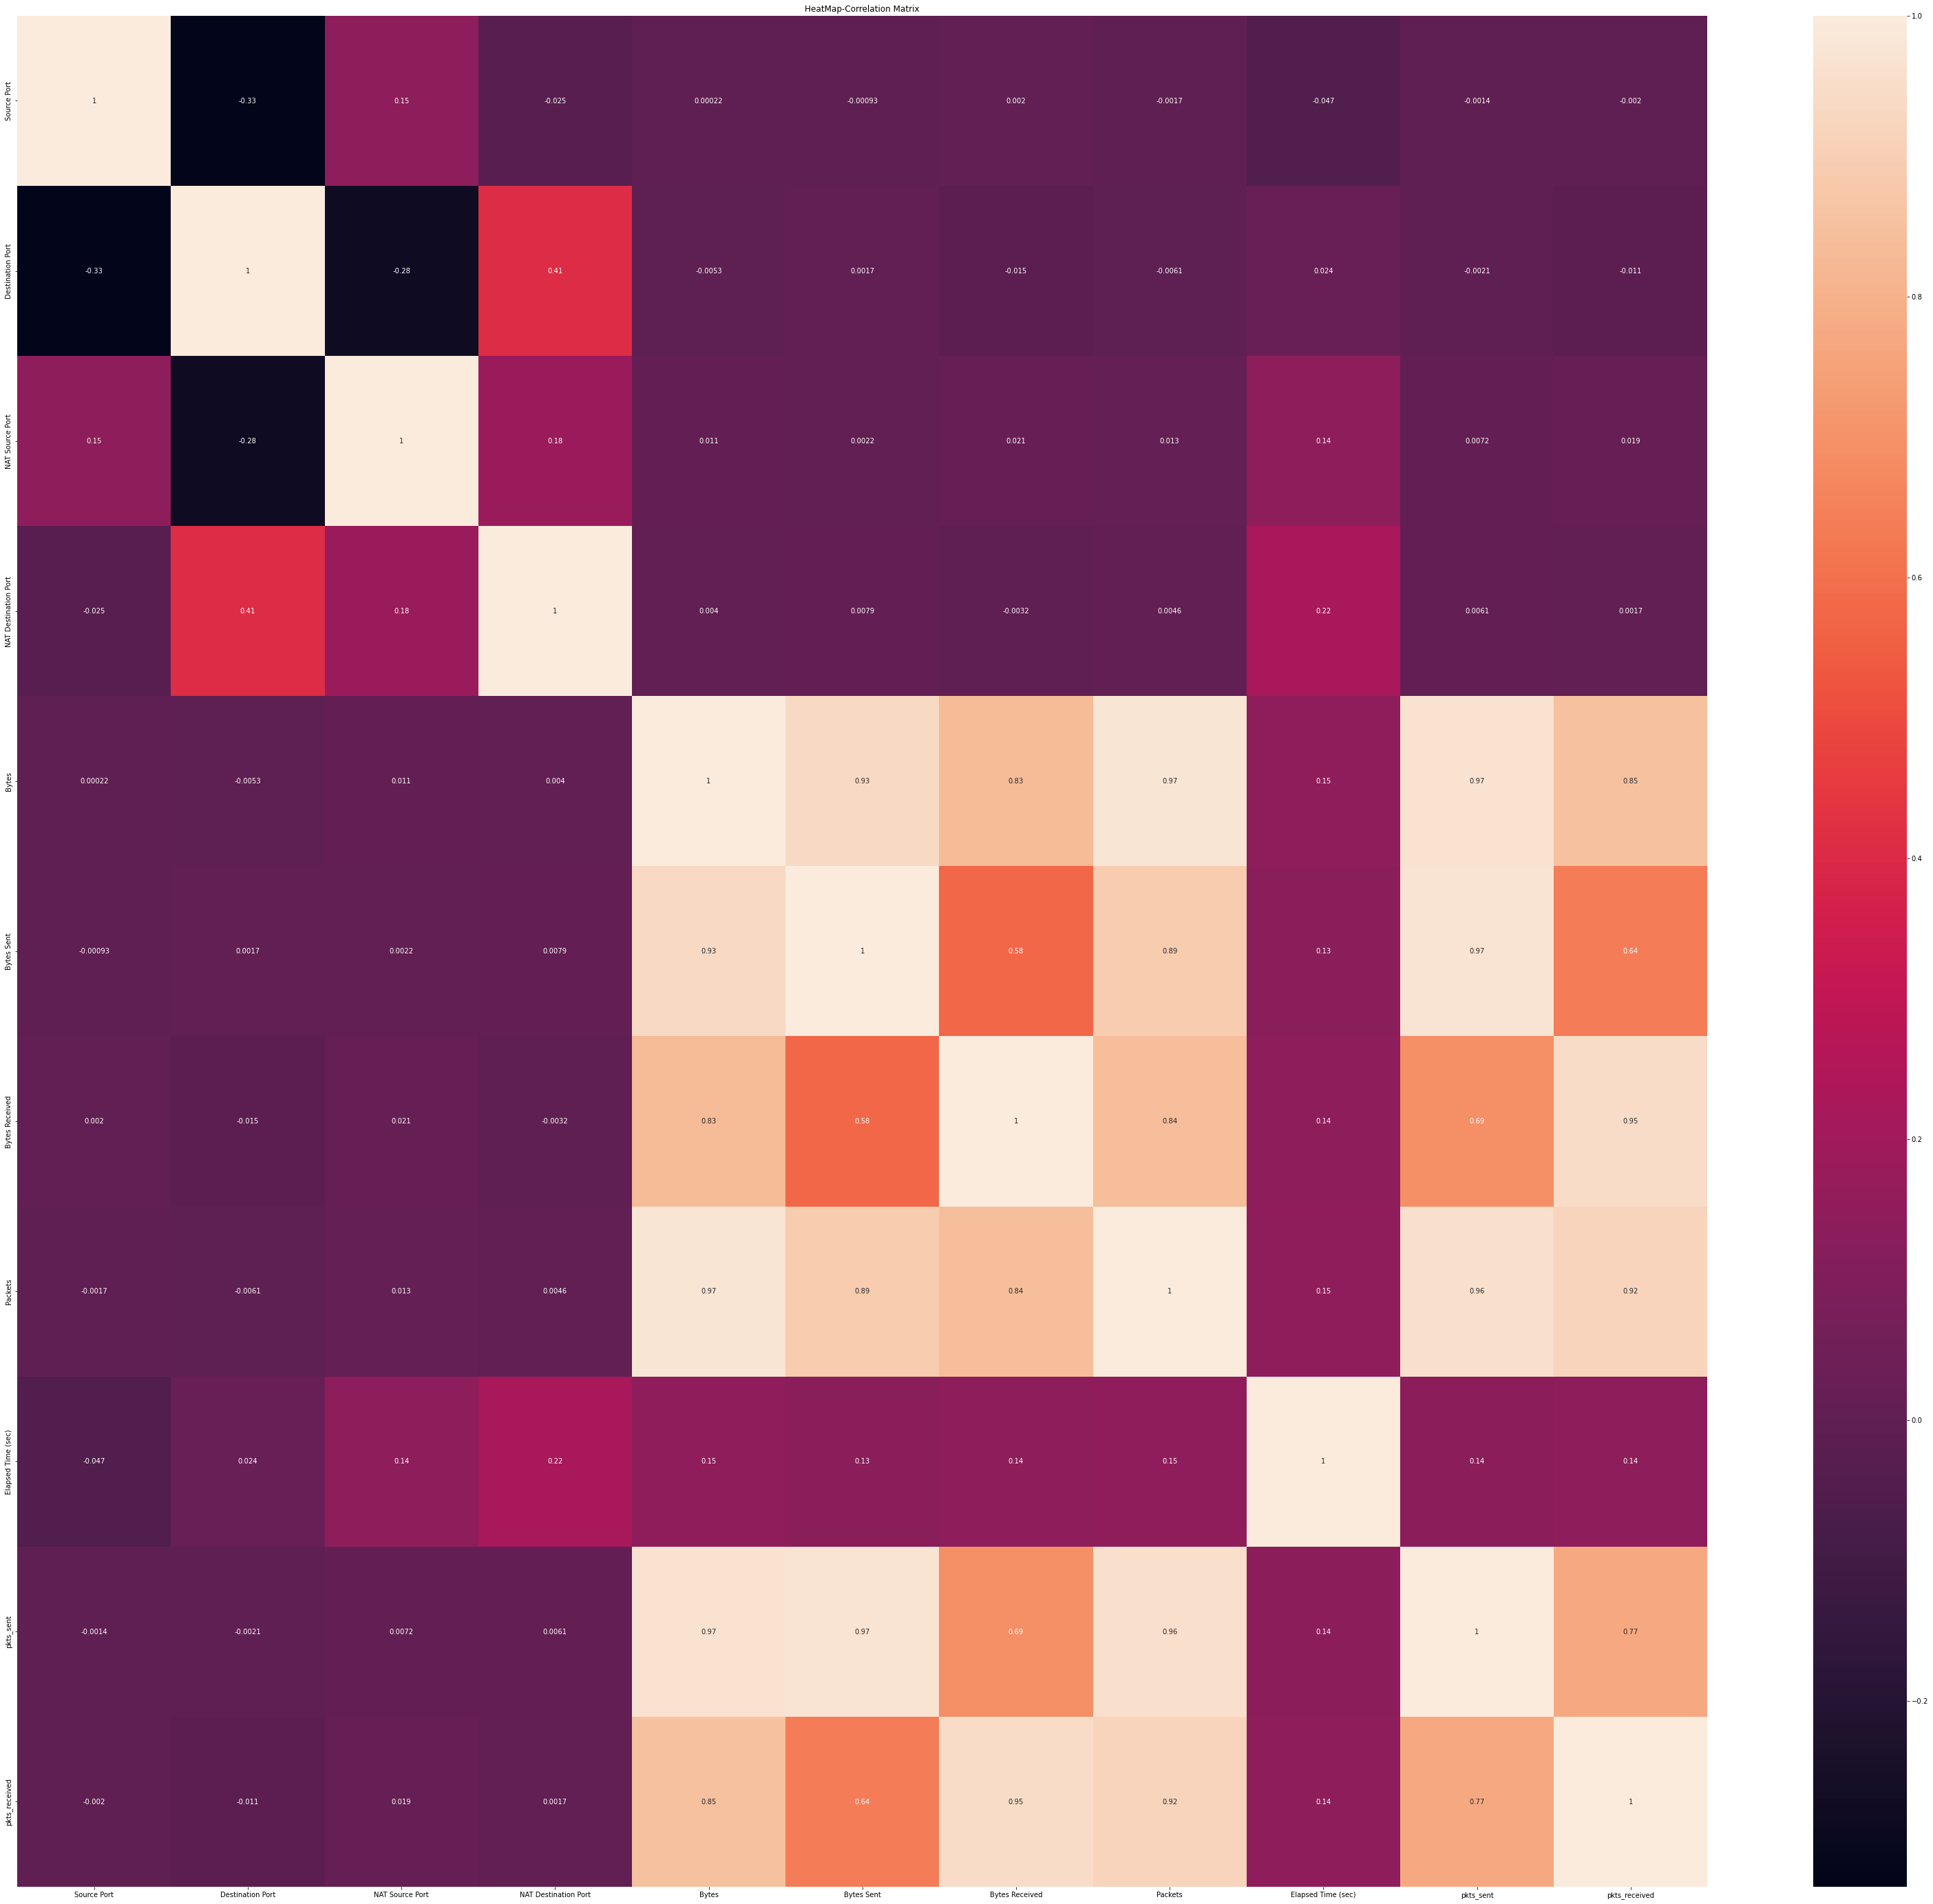

In [17]:
#heatmap - correlation matrix
plt.figure(figsize=(55, 50)) #code reference (5-1)
sns.heatmap(df_X.corr(), annot=True)
plt.title('HeatMap-Correlation Matrix')

##### Check for Multicolliniarity 

In [18]:
#https://www.projectpro.io/recipes/drop-out-highly-correlated-features-in-python
# to drop features with colliniarity more than 95%
pd.set_option('display.max_rows', 100)

corr_df = pd.DataFrame(df_X.corr().abs())
corr_df.head(100)

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
Source Port,1.000000,0.332246,0.145391,0.024843,0.000221,0.000931,0.001950,0.001742,0.046515,0.001422,0.001962
Destination Port,0.332246,1.000000,0.281676,0.410042,0.005297,0.001675,0.014684,0.006063,0.023537,0.002134,0.010909
NAT Source Port,0.145391,0.281676,1.000000,0.178435,0.010659,0.002242,0.020827,0.012633,0.141485,0.007180,0.018772
NAT Destination Port,0.024843,0.410042,0.178435,1.000000,0.003975,0.007904,0.003216,0.004605,0.219776,0.006136,0.001747
Bytes,0.000221,0.005297,0.010659,0.003975,1.000000,0.933462,0.830225,0.974379,0.148834,0.966548,0.850209
Bytes Sent,0.000931,0.001675,0.002242,0.007904,0.933462,1.000000,0.575047,0.887596,0.126039,0.973976,0.639098
Bytes Received,0.001950,0.014684,0.020827,0.003216,0.830225,0.575047,1.000000,0.843067,0.143601,0.690959,0.946039
Packets,0.001742,0.006063,0.012633,0.004605,0.974379,0.887596,0.843067,1.000000,0.147074,0.961286,0.916978
Elapsed Time (sec),0.046515,0.023537,0.141485,0.219776,0.148834,0.126039,0.143601,0.147074,1.000000,0.135101,0.143954
pkts_sent,0.001422,0.002134,0.007180,0.006136,0.966548,0.973976,0.690959,0.961286,0.135101,1.000000,0.771550


In [19]:
# Multi Colliniarity analysis on Independent variables 
upper_tri = corr_df.where(np.triu(np.ones(corr_df.shape),k=1).astype(np.bool))
print(upper_tri)

                      Source Port  Destination Port  NAT Source Port  \
Source Port                   NaN          0.332246         0.145391   
Destination Port              NaN               NaN         0.281676   
NAT Source Port               NaN               NaN              NaN   
NAT Destination Port          NaN               NaN              NaN   
Bytes                         NaN               NaN              NaN   
Bytes Sent                    NaN               NaN              NaN   
Bytes Received                NaN               NaN              NaN   
Packets                       NaN               NaN              NaN   
Elapsed Time (sec)            NaN               NaN              NaN   
pkts_sent                     NaN               NaN              NaN   
pkts_received                 NaN               NaN              NaN   

                      NAT Destination Port     Bytes  Bytes Sent  \
Source Port                       0.024843  0.000221    0.000931   

In [20]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print((to_drop))

['Packets', 'pkts_sent']


In [21]:
X = df.drop(['Action_mod'],axis=1)
ind_columns = df.drop('Action_mod',axis=1).columns
y = df['Action_mod']

We did normalize the attributes using StandardScaler() to scale them between 0 and 1 before running models.

In [22]:
# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [23]:
from sklearn.model_selection import train_test_split
#Direct train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.20, random_state=1234
)

In [24]:
#Create Cross Validation Procedure
cv = StratifiedKFold(n_splits=10, random_state=1234, shuffle=True)

In [25]:
# Model Metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

def displayModel_metrics(best_model, grid_model, features, target, cv):
    metrics = cross_validate(best_model, features, y=target, cv=cv, 
                             scoring=['accuracy','precision','recall', 'f1'], return_train_score=True) 
    
    y_predict = cross_val_predict(best_model, features, target, cv=cv)

    print('\nBest Accuracy with Grid Search            : {:.3f}'.format(grid_model.best_score_))
    print('\nTraining data Metrics')
    print('\n     The average accuraccy : {:.3f}'.format(metrics['train_accuracy'].mean()))
    print('     The average precision : {:.3f}'.format(metrics['train_precision'].mean()))
    print('     The average recall    : {:.3f}'.format(metrics['train_recall'].mean()))
    print('     The average f1 score    : {:.3f}'.format(metrics['train_f1'].mean()))

    print('\nTest data Metrics')
    print('\n     The average accuracy  : {:.3f}'.format(metrics['test_accuracy'].mean()))
    print('     The average precision : {:.3f}'.format(metrics['test_precision'].mean()))
    print('     The average  recall   : {:.3f}'.format(metrics['test_recall'].mean()))
    print('     The average f1 score    : {:.3f}'.format(metrics['test_f1'].mean()))
    
    matrix = classification_report(target, y_predict, labels=[1,0])
    print('\nClassification report\n')
    print(matrix)

In [26]:
# Reference https://github.com/jakemdrew/DataMiningNotebooks/blob/master/06.%20Classification.ipynb
# ROC curve plot
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn import metrics as mt

def roc_curve_plot(model_fit, features, target):

    sns.set_palette("dark")

    yhat_score = model_fit.predict_proba(features)

    # Compute ROC curve for a subset of interesting classes
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in np.unique(target):
        fpr[i], tpr[i], _ = mt.roc_curve(y, yhat_score[:, i], pos_label=i)
        roc_auc[i] = mt.auc(fpr[i], tpr[i])

    for i in np.unique(target):
        plt.plot(fpr[i], tpr[i], label= ('class %d (area = %0.2f)' % (i, roc_auc[i])))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    plt.legend(loc="lower right")  
    plt.title('Receiver operating characteristic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

### Support Vector Machine (SVM)

GridSearch Parameters:

C: Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty.

class_weight: Set the parameter C of class i to class_weight[i]*C for SVC. If not given, all classes are supposed to have weight one. The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)). 

kernel: Specifies the kernel type to be used in the algorithm. If none is given, ‘rbf’ will be used. If a callable is given it is used to pre-compute the kernel matrix from data matrices; that matrix should be an array of shape (n_samples, n_samples)

In [27]:
from sklearn import svm

SVM = svm.SVC()

# define parameters
C_SVM = [0.1, 1, 5, 10]
class_weight_SVM = ['balanced', None]
kernel_SVM = ['linear', 'poly', 'rbf']
random_state_SVM = [1234]

# define grid search

param_grid_SVM = dict(C=C_SVM, class_weight=class_weight_SVM, kernel=kernel_SVM,
                      random_state=random_state_SVM)

grid_search_SVM = GridSearchCV(estimator=SVM, param_grid=param_grid_SVM, n_jobs=10, cv=cv, 
                               scoring='accuracy',error_score=0, verbose=1)

In [28]:
%%time
grid_result_SVM = grid_search_SVM.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result_SVM.best_score_, grid_result_SVM.best_params_))
means = grid_result_SVM.cv_results_['mean_test_score']
stds = grid_result_SVM.cv_results_['std_test_score']
params = grid_result_SVM.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 24 candidates, totalling 240 fits
Best: 0.997940 using {'C': 10, 'class_weight': None, 'kernel': 'rbf', 'random_state': 1234}
0.992771 (0.000711) with: {'C': 0.1, 'class_weight': 'balanced', 'kernel': 'linear', 'random_state': 1234}
0.945579 (0.008331) with: {'C': 0.1, 'class_weight': 'balanced', 'kernel': 'poly', 'random_state': 1234}
0.980296 (0.002211) with: {'C': 0.1, 'class_weight': 'balanced', 'kernel': 'rbf', 'random_state': 1234}
0.992961 (0.000600) with: {'C': 0.1, 'class_weight': None, 'kernel': 'linear', 'random_state': 1234}
0.959428 (0.005071) with: {'C': 0.1, 'class_weight': None, 'kernel': 'poly', 'random_state': 1234}
0.981688 (0.001941) with: {'C': 0.1, 'class_weight': None, 'kernel': 'rbf', 'random_state': 1234}
0.997539 (0.000543) with: {'C': 1, 'class_weight': 'balanced', 'kernel': 'linear', 'random_state': 1234}
0.976633 (0.003497) with: {'C': 1, 'class_weight': 'balanced', 'kernel': 'poly', 'random_state': 1234}
0.996757 (0.000682) wit

In [29]:
# The GridSearch algorithm determined the following optimal parameters
best_Estimator_SVM =grid_result_SVM.best_estimator_
best_Estimator_SVM

SVC(C=10, random_state=1234)

In [30]:
# Display model metrics
displayModel_metrics(best_Estimator_SVM, grid_result_SVM, X_train, y_train, cv)


Best Accuracy with Grid Search            : 0.998

Training data Metrics

     The average accuraccy : 0.998
     The average precision : 0.999
     The average recall    : 0.997
     The average f1 score    : 0.998

Test data Metrics

     The average accuracy  : 0.998
     The average precision : 0.999
     The average  recall   : 0.997
     The average f1 score    : 0.998

Classification report

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     30079
           0       1.00      1.00      1.00     22346

    accuracy                           1.00     52425
   macro avg       1.00      1.00      1.00     52425
weighted avg       1.00      1.00      1.00     52425



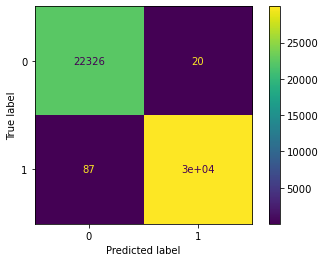

In [31]:
# training data confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

predictions = grid_result_SVM.predict(X_train)
cm = confusion_matrix(y_train, predictions, labels=grid_result_SVM.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=grid_result_SVM.classes_)
disp.plot()
plt.show()

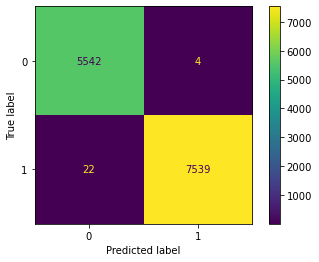

In [32]:
# test data confusion matrix
predictions = grid_result_SVM.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=grid_result_SVM.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=grid_result_SVM.classes_)
disp.plot()
plt.show()

In [33]:
# Test Accuracy Precision and recall
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
predictions = grid_result_SVM.predict(X_test)
print("Precision:", accuracy_score(y_test, predictions))
print("Recall   :", recall_score(y_test, predictions, average='binary'))
print("Precision:", precision_score(y_test, predictions, average='binary'))

Precision: 0.9980163271534295
Recall   : 0.9970903319666711
Precision: 0.9994697070131248


Text(0.5, 1.0, 'Precision-Recall Curve')

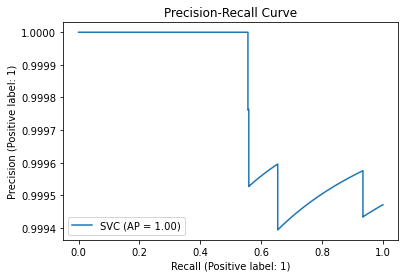

In [34]:
# Precision recall curve for Test data
disp = plot_precision_recall_curve(best_Estimator_SVM, X_test, y_test)
disp.ax_.set_title('Precision-Recall Curve')

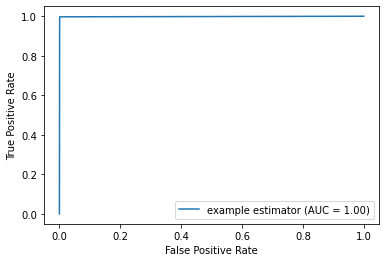

In [35]:
# ROC curve for Test data
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, grid_result_SVM.predict(X_test))
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='example estimator')
display.plot()
plt.show()

In [36]:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
best_Estimator_SVM.support_vectors_.shape

(807, 11)

In [37]:
best_Estimator_SVM.n_support_ 

array([418, 389])

In [38]:
df_support = df.iloc[best_Estimator_SVM.support_,:].copy()

In [39]:
df_support.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,Action_mod
148,51125,445,0,0,66,66,0,1,0,1,0,0
394,52157,80,19874,80,366,240,126,7,32,5,2,1
421,56741,53,5499,53,370,94,276,2,30,1,1,1
450,37647,443,55661,443,697381,19797,677584,725,106,247,478,1
659,50880,445,0,0,70,70,0,1,0,1,0,0


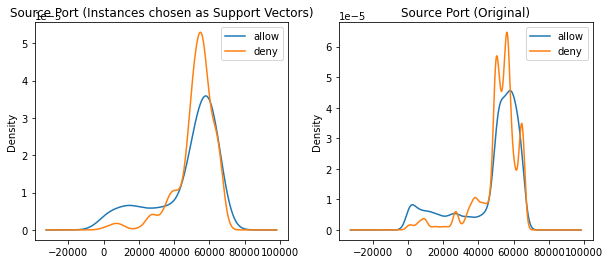

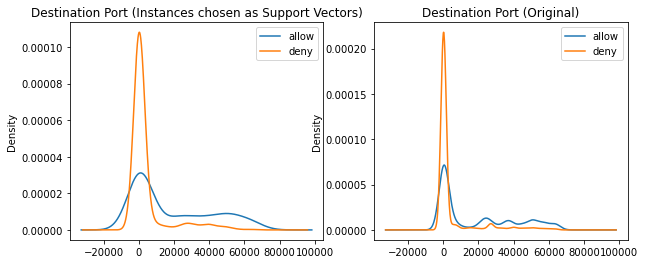

In [40]:
# plot KDE of Different variables
# group the original data and the support vectors
df_grouped_support = df_support.groupby(['Action_mod'])
df_grouped = df.groupby(['Action_mod'])

vars_to_plot = ['Source Port','Destination Port']
for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['allow','deny'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['allow','deny'])
    plt.title(v+' (Original)')

### Feature Importance

Text(0.5, 0, 'Permutation Importance')

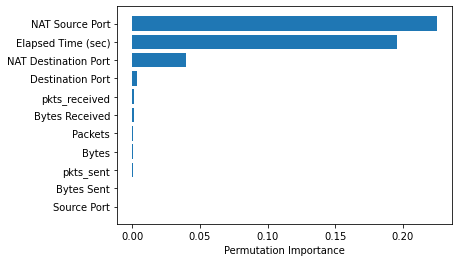

In [41]:
# https://stackoverflow.com/questions/41592661/determining-the-most-contributing-features-for-svm-classifier-in-sklearn
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(grid_search_SVM.best_estimator_, X_train, y_train)

feature_names = df.columns
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

### Stochastic Gradient Descent (SGD)

GridSearch Parameters:

loss: The possible options are ‘hinge’, ‘log’, ‘modified_huber’, ‘squared_hinge’, ‘perceptron’, or a regression loss: ‘squared_loss’, ‘huber’, ‘epsilon_insensitive’, or ‘squared_epsilon_insensitive’

penalty: The penalty (aka regularization term), Defaults to ‘l2’ which is the standard regularizer for linear SVM models. ‘l1’ and ‘elasticnet’ might bring sparsity to the model

alpha: Constant that multiplies the regularization term, The higher the value, the stronger the regularization. Also used to compute the learning rate when set to learning_rate is set to ‘optimal’

class_weight: Weights associated with classes. If not given, all classes are supposed to have weight one. 

max_iter: The maximum number of passes over the training data (aka epochs).

In [42]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html?highlight=sgdclassifier#sklearn.linear_model.SGDClassifier
#SVM_SGD 
from sklearn import svm
from sklearn.linear_model import SGDClassifier

SGD = SGDClassifier()

# define parameters
loss_SGD = ['modified_huber', 'hinge']
penalty_SGD = ['l2']
alpha_SGD = [0.00001,0.00005, 0.0001, 0.0005, 0.001, 0.03, 0.01, 0.1, 1]
class_weight_SGD = ['balanced', None]
max_iter_SGD = [100, 200, 300]
random_state_SGD = [1234]

# define grid search
param_grid_SGD = dict(loss=loss_SGD, penalty=penalty_SGD, alpha=alpha_SGD,
                     class_weight=class_weight_SGD, max_iter=max_iter_SGD, random_state=random_state_SGD)


grid_search_SGD = GridSearchCV(estimator=SGD, param_grid=param_grid_SGD, n_jobs=10, cv=cv, 
                               scoring='accuracy',error_score=0, verbose=1)

In [43]:
%%time
grid_result_SGD = grid_search_SGD.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result_SGD.best_score_, grid_result_SGD.best_params_))
means = grid_result_SGD.cv_results_['mean_test_score']
stds = grid_result_SGD.cv_results_['std_test_score']
params = grid_result_SGD.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 108 candidates, totalling 1080 fits
Best: 0.997635 using {'alpha': 0.0001, 'class_weight': None, 'loss': 'hinge', 'max_iter': 100, 'penalty': 'l2', 'random_state': 1234}
0.996128 (0.001242) with: {'alpha': 1e-05, 'class_weight': 'balanced', 'loss': 'modified_huber', 'max_iter': 100, 'penalty': 'l2', 'random_state': 1234}
0.996128 (0.001242) with: {'alpha': 1e-05, 'class_weight': 'balanced', 'loss': 'modified_huber', 'max_iter': 200, 'penalty': 'l2', 'random_state': 1234}
0.996128 (0.001242) with: {'alpha': 1e-05, 'class_weight': 'balanced', 'loss': 'modified_huber', 'max_iter': 300, 'penalty': 'l2', 'random_state': 1234}
0.997330 (0.000768) with: {'alpha': 1e-05, 'class_weight': 'balanced', 'loss': 'hinge', 'max_iter': 100, 'penalty': 'l2', 'random_state': 1234}
0.997330 (0.000768) with: {'alpha': 1e-05, 'class_weight': 'balanced', 'loss': 'hinge', 'max_iter': 200, 'penalty': 'l2', 'random_state': 1234}
0.997330 (0.000768) with: {'alpha': 1e-05, 'class_weig

In [44]:
# The GridSearch algorithm determined the following optimal parameters
best_Estimator_SGD =grid_result_SGD.best_estimator_
best_Estimator_SGD

SGDClassifier(max_iter=100, random_state=1234)

In [45]:
# Display model metrics
displayModel_metrics(best_Estimator_SGD, grid_result_SGD, X_train, y_train, cv)


Best Accuracy with Grid Search            : 0.998

Training data Metrics

     The average accuraccy : 0.998
     The average precision : 0.999
     The average recall    : 0.997
     The average f1 score    : 0.998

Test data Metrics

     The average accuracy  : 0.998
     The average precision : 0.999
     The average  recall   : 0.997
     The average f1 score    : 0.998

Classification report

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     30079
           0       1.00      1.00      1.00     22346

    accuracy                           1.00     52425
   macro avg       1.00      1.00      1.00     52425
weighted avg       1.00      1.00      1.00     52425



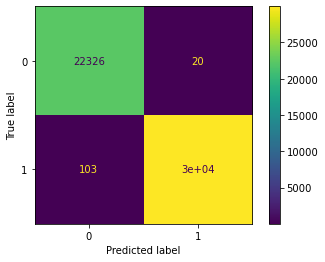

In [46]:
# training data confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

predictions = grid_result_SGD.predict(X_train)
cm = confusion_matrix(y_train, predictions, labels=grid_result_SGD.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=grid_result_SGD.classes_)
disp.plot()
plt.show()

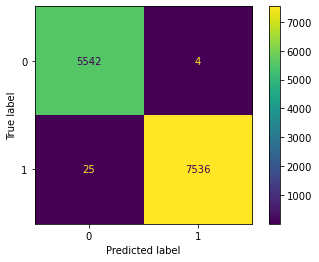

In [47]:
# test data confusion matrix
predictions = grid_result_SGD.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=grid_result_SGD.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=grid_result_SGD.classes_)
disp.plot()
plt.show()

In [48]:
# Test Accuracy Precision and recall
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
predictions = grid_result_SGD.predict(X_test)
print("Precision:", accuracy_score(y_test, predictions))
print("Recall   :", recall_score(y_test, predictions, average='binary'))
print("Precision:", precision_score(y_test, predictions, average='binary'))

Precision: 0.997787441824979
Recall   : 0.9966935590530354
Precision: 0.9994694960212201


Text(0.5, 1.0, 'Precision-Recall Curve')

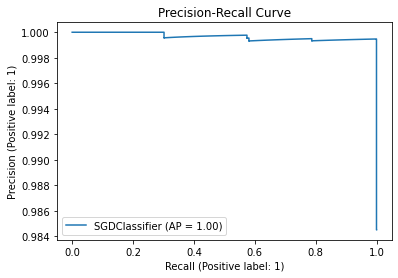

In [49]:
# Precision recall curve for Test data
disp = plot_precision_recall_curve(best_Estimator_SGD, X_test, y_test)
disp.ax_.set_title('Precision-Recall Curve (Test Data)')

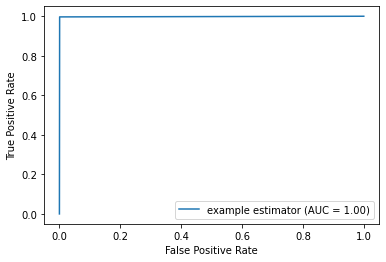

In [50]:
# ROC curve for Test data
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, grid_result_SGD.predict(X_test))
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='example estimator')
display.plot()
plt.show()

<BarContainer object of 11 artists>

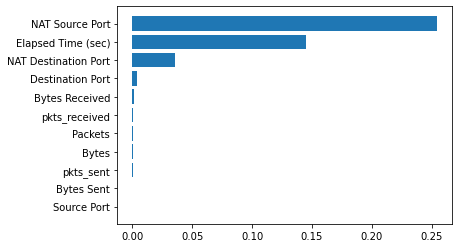

In [51]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(grid_search_SGD.best_estimator_, X_train, y_train)

feature_names = df.columns
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])

### Reduced dataset with port numbers as categorical

In [52]:
print(len(df['Source Port'].value_counts()))
print(len(df['Destination Port'].value_counts()))
print(len(df['NAT Source Port'].value_counts()))
print(len(df['NAT Destination Port'].value_counts()))

22724
3273
29152
2533


In [53]:
df.columns

Index(['Source Port', 'Destination Port', 'NAT Source Port',
       'NAT Destination Port', 'Bytes', 'Bytes Sent', 'Bytes Received',
       'Packets', 'Elapsed Time (sec)', 'pkts_sent', 'pkts_received',
       'Action_mod'],
      dtype='object')

In [54]:
df_reduced = df.sample(frac=0.2, replace=False, random_state=1)

In [55]:
df_reduced.shape

(13106, 12)

In [56]:
df_reduced.Action_mod.value_counts()

1    7431
0    5675
Name: Action_mod, dtype: int64

In [57]:
df_reduced = pd.get_dummies(df_reduced, columns=['Source Port','Destination Port','NAT Source Port','NAT Destination Port'])

In [58]:
df_reduced.shape

(13106, 18103)

In [59]:
df_reduced.head()

,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,Action_mod,Source Port_0,Source Port_22,...,NAT Destination Port_64337,NAT Destination Port_64509,NAT Destination Port_64722,NAT Destination Port_64745,NAT Destination Port_64767,NAT Destination Port_64823,NAT Destination Port_64919,NAT Destination Port_65264,NAT Destination Port_65387,NAT Destination Port_65427
12284,217,86,131,2,30,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
64627,66,66,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41220,70,70,0,2,8,2,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
32498,195,102,93,2,31,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1131,217,87,130,2,31,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
X_reduced = df_reduced.drop(['Action_mod'],axis=1)
y_reduced = df_reduced['Action_mod']

In [61]:
# Normalize the data
scaler = StandardScaler()
X_reduced_scaled = scaler.fit_transform(X_reduced)

In [62]:
from sklearn.model_selection import train_test_split
#Direct train/test split
X_reduced_train, X_reduced_test, y_reduced_train, y_reduced_test = train_test_split(
    X_reduced_scaled, y_reduced, test_size=0.10, random_state=1234
)

### SVM

In [63]:
%%time
SVM_clf = svm.SVC(C=10, kernel='linear', random_state=1234)
SVM_clf.fit(X_reduced_train, y_reduced_train)

Wall time: 13min 11s


SVC(C=10, kernel='linear', random_state=1234)

In [64]:
# # cross validation
# cv_df = pd.DataFrame(cross_validate(SVM_clf, X_reduced_train, y_reduced_train, cv=cv, scoring=['accuracy','precision','recall', 'f1'], n_jobs=-1))
# cv_df

In [65]:
# train accuracy score
y_hat = SVM_clf.predict(X_reduced_train)
print("Training Data Metrics\n")
print("Accuracy:", accuracy_score(y_reduced_train, y_hat))
print("Recall   :", recall_score(y_reduced_train, y_hat, average='binary'))
print("Precision:", precision_score(y_reduced_train, y_hat, average='binary'))

Training Data Metrics

Accuracy: 0.9991521831284442
Recall   : 1.0
Precision: 0.9985063480209111


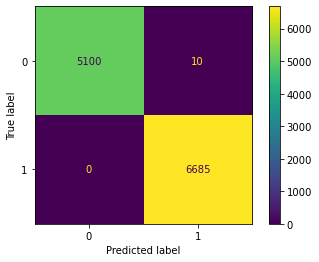

In [66]:
# Traning data Confusion matrix
cm = confusion_matrix(y_reduced_train, y_hat, labels=SVM_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=SVM_clf.classes_)
disp.plot()
plt.show()

In [67]:
# test accuracy score, precision and recall
y_hat = SVM_clf.predict(X_reduced_test)
print("Accuracy:", accuracy_score(y_reduced_test, y_hat))
print("Recall   :", recall_score(y_reduced_test, y_hat, average='binary'))
print("Precision:", precision_score(y_reduced_test, y_hat, average='binary'))

Accuracy: 0.9664378337147216
Recall   : 0.9450402144772118
Precision: 0.9957627118644068


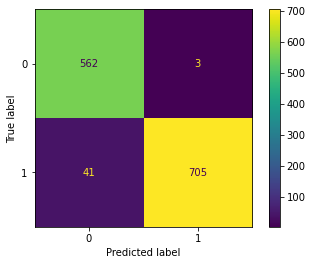

In [68]:
# Test Data Confusion matrix
cm = confusion_matrix(y_reduced_test, y_hat, labels=SVM_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=SVM_clf.classes_)
disp.plot()
plt.show()

##### Support vectors

In [69]:
# Support vectors
SVM_clf.support_vectors_.shape

(4736, 18102)

In [70]:
SVM_clf.n_support_ 

array([2081, 2655])

#### Feature Importance

In [71]:
# from sklearn.inspection import permutation_importance
# perm_importance = permutation_importance(SVM_clf, X_reduced_train, y_reduced_train)

# feature_names = df_reduced.columns
# features = np.array(feature_names)

# sorted_idx = perm_importance.importances_mean.argsort()
# plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])

### SGD

In [72]:
%%time
SGD_clf = SGDClassifier(alpha=0.0001, loss='hinge', penalty='l2', random_state=1234)
SGD_clf.fit(X_reduced_train, y_reduced_train)

Wall time: 7.88 s


SGDClassifier(random_state=1234)

In [73]:
# cross validation
cv_df = pd.DataFrame(cross_validate(SGD_clf, X_reduced_train, y_reduced_train, cv=cv, scoring=['accuracy','precision','recall', 'f1'], n_jobs=-1))
cv_df

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1
0,44.493826,0.559863,0.666102,0.629351,1.000000,0.772517
1,32.237747,1.773477,0.694915,0.650146,1.000000,0.787986
2,34.225653,0.979251,0.676271,0.636537,1.000000,0.777907
3,41.881539,1.399696,0.678814,0.638359,1.000000,0.779266
4,50.630302,0.402044,0.667797,0.630537,1.000000,0.773410
5,26.310546,0.407391,0.687023,0.644166,1.000000,0.783578
6,45.293321,0.192916,0.692960,0.648544,1.000000,0.786808
7,43.386847,0.317335,0.893978,0.844106,0.997006,0.914207
8,20.759117,0.083506,0.686175,0.644660,0.994012,0.782097
9,12.997172,0.074970,0.897371,0.849298,0.995509,0.916609


In [74]:
# train accuracy score
y_hat = SGD_clf.predict(X_reduced_train)
print("Training Data Metrics\n")
print("Precision:", accuracy_score(y_reduced_train, y_hat))
print("Recall   :", recall_score(y_reduced_train, y_hat, average='binary'))
print("Precision:", precision_score(y_reduced_train, y_hat, average='binary'))

Training Data Metrics

Precision: 0.9968630775752437
Recall   : 0.9974569932685116
Precision: 0.9970095693779905


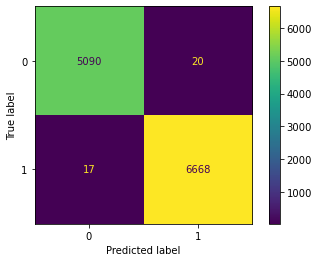

In [75]:
# Training data Confusion matrix
cm = confusion_matrix(y_reduced_train, y_hat, labels=SGD_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=SGD_clf.classes_)
disp.plot()
plt.show()

In [76]:
# test accuracy score, precision and recall
y_hat = SGD_clf.predict(X_reduced_test)
print("Test Data Metrics\n")
print("Accuracy:", accuracy_score(y_reduced_test, y_hat))
print("Recall   :", recall_score(y_reduced_test, y_hat, average='binary'))
print("Precision:", precision_score(y_reduced_test, y_hat, average='binary'))

Test Data Metrics

Accuracy: 0.6956521739130435
Recall   : 0.9973190348525469
Precision: 0.6520595968448729


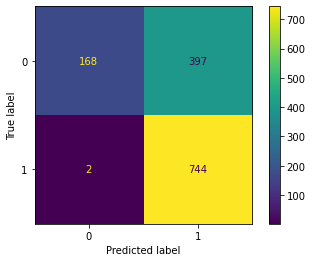

In [77]:
# Test data Confusion matrix
cm = confusion_matrix(y_reduced_test, y_hat, labels=SGD_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=SGD_clf.classes_)
disp.plot()
plt.show()

#### Feature Impotrance

In [ ]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(SGD_clf, X_reduced_train, y_reduced_train)

feature_names = df_reduced.columns
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])